In [1]:
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Launching:
    def __init__(self, start=0, end=100, step=1):
        self.start = start
        self.end = end
        self.step = step
        
        self.X = []
        self.Y = []
        self.r = []
        
        self.Wx = []
        self.Wy = []
        
        self.Vx = []
        self.Vy = []
        self.v = []
        
        self.q = []
    
    def vehicle(self, mass, constr1, fuel1, dm1, abs_w1, constr2, fuel2, dm2, abs_w2):
        
        #stage1
        self.mass = mass
        self.constr1 = constr1
        self.mass_fuel = fuel1
        self.dm = dm1
        self.abs_w = abs_w1
        
        #stage2
        self.constr2 = constr2
        self.mass_fuel2 = fuel2
        self.dm2 = dm2
        self.abs_w2 = abs_w2
        
    def trajectory(self, x_0, y_0, vx_0, vy_0, b):

        grad = pi/180
        M = 5.9722e24 #масса Земли [кг] /  Earth's mass [kg]
        G = 6.674e-20 #гравитационная постоянная [км^3/ кг*c^2] / gravitational constant [km^3 / kg*s^2]
        MU = G*M #гравитационный параметр для Земли [км^3*c^-2] / the gravitational parameter of the Earth [km^3*s^-2]

        self.tetha = 90
        
        self.X.append(x_0)
        self.Y.append(y_0)
        self.r.append([self.X[0], self.Y[0]])
        
        self.Vx.append(vx_0)
        self.Vy.append(vy_0)
        self.v.append([self.Vx[0],self.Vy[0]])
        
        self.q.append([self.start,
                       self.tetha,
                       self.X[0],
                       self.Y[0], 
                       sqrt(self.X[0]**2+self.Y[0]**2),
                       self.Vx[0],
                       self.Vy[0],
                       sqrt(self.Vx[0]**2+self.Vy[0]**2), 
                       self.mass])
        
        self.main = list()
        flag = False

        for t, i in zip(np.arange(self.start, self.end, self.step), range(int(self.end/self.step))):
        
            def tetha(b,t):
                global tt
                tt = 0
                if t<30:
                    return self.tetha
                elif t>=30 and self.tetha>0:
                    tt += 1
                    return (self.tetha-b*tt)
                else:
                    return 0

            self.X.append(self.X[i]+self.Vx[i]*self.step)
            self.Y.append(self.Y[i]+self.Vy[i]*self.step)

            self.r.append([self.X[i],self.Y[i]])
            abs_r = sqrt(self.X[i+1]**2+self.Y[i+1]**2)
            
            self.Wx.append(self.abs_w * self.Vx[i]/sqrt(self.Vx[i]**2+self.Vy[i]**2))
            self.Wy.append(self.abs_w * self.Vy[i]/sqrt(self.Vx[i]**2+self.Vy[i]**2))
            
            self.Vx.append(self.Vx[i]-MU*(self.X[i]/abs_r**3)*self.step+(self.dm*self.Wx[i]*np.cos(self.tetha*grad)/self.mass)*self.step)
            self.Vy.append(self.Vy[i]-MU*(self.Y[i]/abs_r**3)*self.step+(self.dm*self.Wy[i]*np.sin(self.tetha*grad)/self.mass)*self.step)

            self.tetha = tetha(b,t)
            
            self.v.append([self.Vx[i],self.Vy[i]])
            abs_v = sqrt(self.Vx[i+1]**2+self.Vy[i+1]**2)

            if not flag: 
                if self.mass_fuel>=0:
                    self.mass -= self.dm*self.step
                    self.mass_fuel -= self.dm*self.step
                else:
                    flag=True
                    self.mass -= self.constr1
                    self.dm = self.dm2
                    self.mass_fuel = self.mass_fuel2
                    self.abs_w = self.abs_w2
                
            if flag:
                self.mass -= self.dm*self.step
                self.mass_fuel -= self.dm*self.step
                if self.mass_fuel < 0: 
                    break
            
            self.q.append([t+self.step, 
                           self.tetha,
                           self.X[i+1],
                           self.Y[i+1], 
                           abs_r,
                           self.Vx[i+1],
                           self.Vy[i+1], 
                           abs_v, 
                           self.mass])
            
            hk = np.array([0, 6571, 7.8, 0])
            ht = np.array([self.X[i], self.Y[i], self.Vx[i], self.Vy[i]])
            
            if abs((6571 - abs_r)) < 1 and abs(7.8-abs_v)<0.1:
                delta = abs(6571 - abs_r)
                deltaV = abs(7.8-abs_v)
                self.main = [b, self.mass, delta, deltaV, t, True]
                break
            
    def data(self):
        
        return pd.DataFrame(self.q, columns=['t', 'tetha','X', 'Y', '|r|' ,'Vx', 'Vy', '|V|','mass'])
                    

[0.641, 16098, 0.9659060170470184, 0.09301948617297473, 507, True]
[0.642, 16098, 0.7379024223619126, 0.08567706862416458, 507, True]


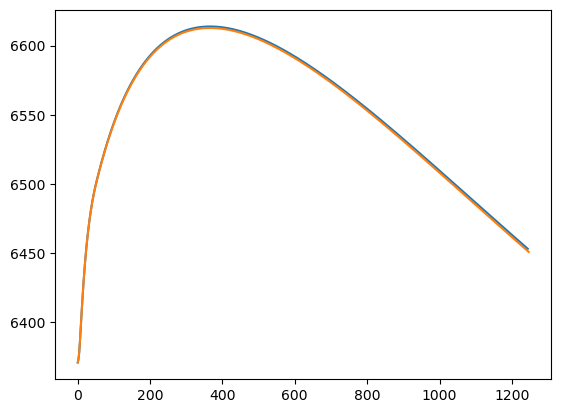

In [2]:
for b in np.arange(0, 1, 0.001):
    lch = Launching(0, 700, 1)
    lch.vehicle(549_000, 22_000, 417_000, 2600, 3.5, 4_000, 106_000, 266, 3.5)
    lch.trajectory(0, 6371, 0.1, 0.1, b)
#     plt.plot(lch.X, lch.Y)
    try:
        if lch.main[-1]:
            plt.plot(lch.X, lch.Y)
            print(lch.main)
    except:
        continue
        
# ax = plt.gca()

# fi = np.linspace(0, 2 * np.pi/2, 100)
# r = 6371
# x = r * np.cos(fi)
# y = r * np.sin(fi)

# ax.plot(x, y, '-')
# plt.axis('scaled')
# plt.show()

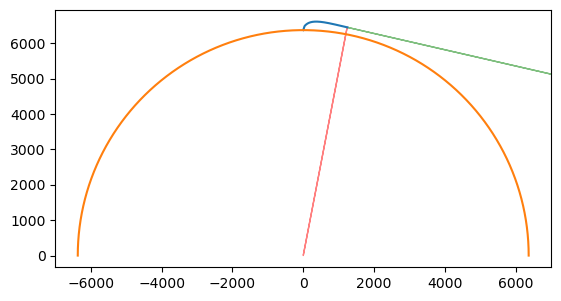

In [3]:
lch = Launching(0, 508, 1)
lch.vehicle(549_000, 22_000, 417_000, 2600, 3.5, 4_000, 106_000, 266, 3.5)
lch.trajectory(0, 6371, 0.1, 0.1, 0.643)
plt.plot(lch.X, lch.Y)

ax = plt.gca()

fi = np.linspace(0, 2 * np.pi/2, 100)
r = 6371
x = r * np.cos(fi)
y = r * np.sin(fi)

ax.plot(x, y, '-')
plt.axis('scaled')

plt.arrow(0,0,1241.548508,6450.455258, alpha=0.5,color='red')
plt.arrow(1241.548508,6450.455258,7472.759,-1716.027, alpha=0.5, color='green')

plt.show()

In [4]:
lch.data()

,t,tetha,X,Y,|r|,Vx,Vy,|V|,mass
0,0,90.0,0.000000,6371.000000,6371.000000,0.100000,0.100000,0.141421,549000
1,1,90.0,0.100000,6371.100000,6371.100001,0.100000,0.101901,0.142772,546400
2,2,90.0,0.200000,6371.201901,6371.201904,0.100000,0.103969,0.144255,543800
3,3,90.0,0.300000,6371.305870,6371.305877,0.100000,0.106211,0.145879,541200
4,4,90.0,0.399999,6371.412082,6371.412094,0.099999,0.108635,0.147653,538600
...,...,...,...,...,...,...,...,...,...
504,504,0.0,1219.443782,6455.548894,6569.714960,7.316823,-1.688803,7.509191,17162
505,505,0.0,1226.760605,6453.860090,6569.417908,7.367967,-1.697879,7.561066,16896
506,506,0.0,1234.128571,6452.162211,6569.130120,7.419936,-1.706953,7.613747,16630
507,507,0.0,1241.548508,6450.455258,6568.851934,7.472759,-1.716027,7.667260,16364
